# Standardized Research

In [1]:
# =============================================================================
# Download files
# =============================================================================
from ninolearn.download import download, sources

download(sources.ONI)
download(sources.IOD)
download(sources.WWV)
# Kirimiti index is used to extend the WWV data (see Bunge and Clarke (2014))
download(sources.KINDEX)


oni.txt already downloaded
iod.txt already downloaded
wwv.dat already downloaded


In [2]:
from ninolearn.preprocess.prepare import prep_oni, prep_wwv
from ninolearn.preprocess.prepare import prep_iod, prep_K_index, prep_wwv_proxy

# =============================================================================
# Prepare the incedes
# =============================================================================
prep_oni()
prep_wwv()
prep_iod()
prep_K_index()
prep_wwv_proxy()

Prepare ONI timeseries.
Prepare WWV  timeseries.
Prepare IOD timeseries.


In [3]:
# =============================================================================
# Here an example of an multilinear (Lasso) regression model is given that is
# based on the scikit-learn python package.
# =============================================================================

# =============================================================================
# First a data pipeline is build. The pipeline is used during training,
# prediction and evaluation to generate the feature, the label, the time
# as well as (optional) the persistance forecast.
# =============================================================================

# import the data reader to read data from the preprocessed data directory
from ninolearn.IO.read_processed import data_reader
import numpy as np

def pipeline(lead_time,  return_persistance=False):
    """
    Data pipeline for the processing of the data before the MLR
    is trained.

    :type lead_time: int
    :param lead_time: The lead time in month.

    :type return_persistance: boolean
    :param return_persistance: Return as the persistance as well.

    :returns: The feature "X" (at observation time), the label "y" (at lead
    time), the target season "timey" (least month) and if selected the
    label at observation time "y_persistance". Hence, the output comes as:
    X, y, timey, y_persistance.
    """
    # initialize the reader
    reader = data_reader(startdate='1960-01', enddate='2017-12')

    # load data
    oni = reader.read_csv('oni')
    wwv = reader.read_csv('wwv_proxy')
    iod = reader.read_csv('iod')

    # the shift data by 3 in addition to lead time shift (due to definition
    # of lead time) as in barnston et al. (2012)
    shift = 3
    # make feature
    Xorg = np.stack((oni, wwv, iod), axis=1)
    X = Xorg[:-lead_time-shift,:]


    # arange label
    yorg = oni.values
    y = yorg[lead_time + shift:]

    # get the time axis of the label
    timey = oni.index[lead_time + shift:]

    if return_persistance:
        y_persistance = yorg[: - lead_time - shift]
        return X, y, timey, y_persistance
    else:
        return X, y, timey


# =============================================================================
# Now the actual model is build.
# =============================================================================

# import the baseModel from which the mlr class needs to inherit
from ninolearn.learn.models.baseModel import baseModel

# import the sklearn model that we want to use for the ENSO forecast
from sklearn.linear_model import Lasso

# import some packages and methods to saving the model later
import pickle
from os.path import join, exists
from os import mkdir

# The actual model inherits from the baseModel class
class mlr(baseModel):

    # Two important variables of the class that each new model needs to define:
    # The number of outputs
    n_outputs=1
    # The name that is used when predictions are saved in an netCDF file.
    output_names = ['prediction']


    def __init__(self, alpha=1.0, name='mlr'):
        """
        The model needs to have an __init__ function. That takes contains
        receives the hyperparameters of the model as well as the name of the
        model as keyword arguments
        """
        # apply the .set_hyperparameters function, that was inherited from the
        # baseModel
        self.set_hyperparameters(alpha=alpha, name=name)

    def fit(self, trainX, trainy):
        """
        This is the fit function of the model. Very complex models, e.g. neural
        networks would need to split the trainX and trainy variables further
        to generate a validation data set, which is than used to calculate
        the self.mean_val_loss and to check for overfitting.
        Here, we don't need to do so because the model is not very complex and
        we have plenty of data to train the model.
        """
        #Initialize the Lasso model form the sci-kit learn package
        self.model = Lasso(self.hyperparameters['alpha'])

        # fit the model to the training data
        self.model.fit(trainX,trainy)

        # IMPORTANT: save the Score under self.mean_val_loss. This variable
        # will be used to be optimized during the random search later
        self.mean_val_loss = self.model.score(trainX, trainy)

    def predict(self, X):
        """
        Prediction function is rather simple when sci-kit learn models are used.
        """
        return self.model.predict(X)

    def save(self, location='', dir_name='mlr'):
        """
        Arguments of this function are mandetory and used to systemically
        save models in your modeldir.
        """
        path = join(location, dir_name)
        if not exists(path):
            mkdir(path)
        filename = join(path,f'model.sav')
        pickle.dump(self.model, open(filename, 'wb'))

    def load(self, location='', dir_name='mlr'):
        """
        Arguments of this function are mandetory and used to systemically
        load models from your modeldir.
        """
        path = join(location, dir_name)
        filename = join(path,f'model.sav')
        self.model = pickle.load(open(filename, 'rb'))

In [4]:
from ninolearn.learn.fit import cross_training
cross_training(mlr, pipeline, 50, alpha=[0.,0.001],  name='mlr')


##################################################################
Lead time: 0 month
##################################################################

Test period: 1962-01-01 till 1971-12-01
--------------------------------------
Search iteration Nr 1/50
New best hyperparameters
Mean loss: 0.8106171438252853
{'alpha': 0.0006600092716088574, 'name': 'mlr'}
Search iteration Nr 2/50
Search iteration Nr 3/50
New best hyperparameters
Mean loss: 0.8106118654117751
{'alpha': 0.0009217598001582531, 'name': 'mlr'}
Search iteration Nr 4/50
New best hyperparameters
Mean loss: 0.8106107285221119
{'alpha': 0.0009689255025913379, 'name': 'mlr'}
Search iteration Nr 5/50
Search iteration Nr 6/50
Search iteration Nr 7/50
Search iteration Nr 8/50
Search iteration Nr 9/50
Search iteration Nr 10/50
Search iteration Nr 11/50
Search iteration Nr 12/50
Search iteration Nr 13/50
Search iteration Nr 14/50
Search iteration Nr 15/50
Search iteration Nr 16/50
Search iteration Nr 17/50
Search iteration Nr 18/5

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.6418752202906, tolerance: 0.04281884809773124
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.000052033707284, tolerance: 0.04281884809773124
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.442456013374525, tolerance: 0.04281884809773124
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

New best hyperparameters
Mean loss: 0.8033569862826081
{'alpha': 0.00098031708274572, 'name': 'mlr'}
Search iteration Nr 16/50
Search iteration Nr 17/50
Search iteration Nr 18/50
Search iteration Nr 19/50
Search iteration Nr 20/50
Search iteration Nr 21/50
Search iteration Nr 22/50
Search iteration Nr 23/50
Search iteration Nr 24/50
Search iteration Nr 25/50
Search iteration Nr 26/50
Search iteration Nr 27/50
Search iteration Nr 28/50
Search iteration Nr 29/50
New best hyperparameters
Mean loss: 0.8033564940260197
{'alpha': 0.0009986811968958065, 'name': 'mlr'}
Search iteration Nr 30/50
Search iteration Nr 31/50
Search iteration Nr 32/50
Search iteration Nr 33/50
Search iteration Nr 34/50
Search iteration Nr 35/50
Search iteration Nr 36/50
Search iteration Nr 37/50
Search iteration Nr 38/50
Search iteration Nr 39/50
Search iteration Nr 40/50
Search iteration Nr 41/50
Search iteration Nr 42/50
Search iteration Nr 43/50
Search iteration Nr 44/50
Search iteration Nr 45/50
Search iteration

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.976859580041314, tolerance: 0.04095336691099477
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.75423773042651, tolerance: 0.04095336691099477
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.34389217078753, tolerance: 0.04095336691099477
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Search iteration Nr 13/50
Search iteration Nr 14/50
Search iteration Nr 15/50
Search iteration Nr 16/50
Search iteration Nr 17/50
Search iteration Nr 18/50
Search iteration Nr 19/50
Search iteration Nr 20/50
Search iteration Nr 21/50
New best hyperparameters
Mean loss: 0.7993635663075673
{'alpha': 0.0009443839991871407, 'name': 'mlr'}
Search iteration Nr 22/50
New best hyperparameters
Mean loss: 0.7993635405315749
{'alpha': 0.0009453331005170556, 'name': 'mlr'}
Search iteration Nr 23/50
Search iteration Nr 24/50
Search iteration Nr 25/50
Search iteration Nr 26/50
Search iteration Nr 27/50
Search iteration Nr 28/50
Search iteration Nr 29/50
Search iteration Nr 30/50
Search iteration Nr 31/50
Search iteration Nr 32/50
Search iteration Nr 33/50
Search iteration Nr 34/50
Search iteration Nr 35/50
Search iteration Nr 36/50
Search iteration Nr 37/50
Search iteration Nr 38/50
Search iteration Nr 39/50
Search iteration Nr 40/50
Search iteration Nr 41/50
Search iteration Nr 42/50
Search iterati

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.20798539360716, tolerance: 0.039655819790575926
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.16528243502016, tolerance: 0.039655819790575926
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.97401995323368, tolerance: 0.039655819790575926
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarnin

Search iteration Nr 17/50
New best hyperparameters
Mean loss: 0.7802806273710199
{'alpha': 0.0009923707679026538, 'name': 'mlr'}
Search iteration Nr 18/50
Search iteration Nr 19/50
Search iteration Nr 20/50
Search iteration Nr 21/50
Search iteration Nr 22/50
Search iteration Nr 23/50
Search iteration Nr 24/50
Search iteration Nr 25/50
Search iteration Nr 26/50
Search iteration Nr 27/50
Search iteration Nr 28/50
Search iteration Nr 29/50
Search iteration Nr 30/50
Search iteration Nr 31/50
Search iteration Nr 32/50
Search iteration Nr 33/50
Search iteration Nr 34/50
Search iteration Nr 35/50
Search iteration Nr 36/50
Search iteration Nr 37/50
Search iteration Nr 38/50
Search iteration Nr 39/50
Search iteration Nr 40/50
Search iteration Nr 41/50
Search iteration Nr 42/50
Search iteration Nr 43/50
Search iteration Nr 44/50
Search iteration Nr 45/50
Search iteration Nr 46/50
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the mod

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.92899032501522, tolerance: 0.03857872286212915
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.7300967094632, tolerance: 0.03857872286212915
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.928864353263, tolerance: 0.03857872286212915
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Obj

Search iteration Nr 31/50
Search iteration Nr 32/50
Search iteration Nr 33/50
Search iteration Nr 34/50
Search iteration Nr 35/50
Search iteration Nr 36/50
Search iteration Nr 37/50
Search iteration Nr 38/50
Search iteration Nr 39/50
Search iteration Nr 40/50
Search iteration Nr 41/50
Search iteration Nr 42/50
Search iteration Nr 43/50
Search iteration Nr 44/50
Search iteration Nr 45/50
Search iteration Nr 46/50
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamters
{'alpha': 0.00099630180879707, 'name': 'mlr'}
best loss search: 0.8173448156074692
loss refitting : 0.8173448156074692
Test period: 2012-01-01 till 2017-12-01
--------------------------------------
Search iteration Nr 1/50
New best hyperparameters
Mean loss: 0.7984468329555162
{'alpha': 0.0009165050072234843, 'name': 'mlr'}
Search iteration Nr 2/50
Search iteration Nr 3/50
New best hyperparameters
Mean loss: 0.7984466705070639
{'alpha'

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.99323875209551, tolerance: 0.042236785863874346
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.85933419903152, tolerance: 0.042236785863874346
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.34410961718007, tolerance: 0.04380148128824477
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning


##################################################################
Lead time: 3 month
##################################################################

Test period: 1962-01-01 till 1971-12-01
--------------------------------------
Search iteration Nr 1/50
New best hyperparameters
Mean loss: 0.49092463249296947
{'alpha': 1.7435506551913616e-05, 'name': 'mlr'}
Search iteration Nr 2/50
New best hyperparameters
Mean loss: 0.490921607173534
{'alpha': 0.0004803214559196922, 'name': 'mlr'}
Search iteration Nr 3/50
Search iteration Nr 4/50
New best hyperparameters
Mean loss: 0.49091744630033796
{'alpha': 0.0007399971751528724, 'name': 'mlr'}
Search iteration Nr 5/50
New best hyperparameters
Mean loss: 0.49091351070582645
{'alpha': 0.0009205031139008092, 'name': 'mlr'}
Search iteration Nr 6/50
Search iteration Nr 7/50
Search iteration Nr 8/50
Search iteration Nr 9/50
New best hyperparameters
Mean loss: 0.49091263380374683
{'alpha': 0.0009560908924513616, 'name': 'mlr'}
Search iteration Nr 10

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98.98075327766787, tolerance: 0.04281813089473684
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.41555328446553, tolerance: 0.04281813089473684
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102.03423315872149, tolerance: 0.04281813089473684
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning

Search iteration Nr 25/50
Search iteration Nr 26/50
Search iteration Nr 27/50
New best hyperparameters
Mean loss: 0.48712767415712865
{'alpha': 0.0009849108427046319, 'name': 'mlr'}
Search iteration Nr 28/50
Search iteration Nr 29/50
Search iteration Nr 30/50
Search iteration Nr 31/50
Search iteration Nr 32/50
Search iteration Nr 33/50
Search iteration Nr 34/50
Search iteration Nr 35/50
Search iteration Nr 36/50
Search iteration Nr 37/50
Search iteration Nr 38/50
Search iteration Nr 39/50
Search iteration Nr 40/50
Search iteration Nr 41/50
Search iteration Nr 42/50
Search iteration Nr 43/50
Search iteration Nr 44/50
Search iteration Nr 45/50
Search iteration Nr 46/50
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamters
{'alpha': 0.0009849108427046319, 'name': 'mlr'}
best loss search: 0.48712767415712865
loss refitting : 0.48712767415712865
Test period: 1982-01-01 till 1991-12-01
----------------

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.75114413717591, tolerance: 0.04095175024561404
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.52488060131617, tolerance: 0.04095175024561404
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.83149137709904, tolerance: 0.04095175024561404
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Search iteration Nr 40/50
Search iteration Nr 41/50
Search iteration Nr 42/50
Search iteration Nr 43/50
Search iteration Nr 44/50
Search iteration Nr 45/50
Search iteration Nr 46/50
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamters
{'alpha': 0.0009690104119765161, 'name': 'mlr'}
best loss search: 0.4414485938406794
loss refitting : 0.4414485938406794
Test period: 1992-01-01 till 2001-12-01
--------------------------------------
Search iteration Nr 1/50
New best hyperparameters
Mean loss: 0.40804431263698315
{'alpha': 0.0006561048486659236, 'name': 'mlr'}
Search iteration Nr 2/50
Search iteration Nr 3/50
Search iteration Nr 4/50
Search iteration Nr 5/50
New best hyperparameters
Mean loss: 0.4080441962699191
{'alpha': 0.0006915576302230957, 'name': 'mlr'}
Search iteration Nr 6/50
Search iteration Nr 7/50
Search iteration Nr 8/50
Search iteration Nr 9/50
New best hyperparameters
Mean loss: 0.408

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.15061930891042, tolerance: 0.03965519614035089
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 113.69274008774086, tolerance: 0.038577602877192974
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112.44024280960495, tolerance: 0.038577602877192974
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarni

Search iteration Nr 3/50
Search iteration Nr 4/50
Search iteration Nr 5/50
New best hyperparameters
Mean loss: 0.5028195770548228
{'alpha': 0.0009886988729149947, 'name': 'mlr'}
Search iteration Nr 6/50
Search iteration Nr 7/50
Search iteration Nr 8/50
Search iteration Nr 9/50
Search iteration Nr 10/50
Search iteration Nr 11/50
Search iteration Nr 12/50
Search iteration Nr 13/50
Search iteration Nr 14/50
Search iteration Nr 15/50
Search iteration Nr 16/50
Search iteration Nr 17/50
Search iteration Nr 18/50
Search iteration Nr 19/50
Search iteration Nr 20/50
Search iteration Nr 21/50
Search iteration Nr 22/50
Search iteration Nr 23/50
Search iteration Nr 24/50
Search iteration Nr 25/50
Search iteration Nr 26/50
Search iteration Nr 27/50
Search iteration Nr 28/50
Search iteration Nr 29/50
Search iteration Nr 30/50
Search iteration Nr 31/50
Search iteration Nr 32/50
Search iteration Nr 33/50
Search iteration Nr 34/50
Search iteration Nr 35/50
Search iteration Nr 36/50
Search iteration Nr 

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.56546916795268, tolerance: 0.04223538471929825
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.02855680046095, tolerance: 0.04223538471929825
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.25901053864148, tolerance: 0.04223538471929825
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarnin

Search iteration Nr 31/50
Search iteration Nr 32/50
Search iteration Nr 33/50
New best hyperparameters
Mean loss: 0.45870193738503945
{'alpha': 0.0009951396639251776, 'name': 'mlr'}
Search iteration Nr 34/50
Search iteration Nr 35/50
Search iteration Nr 36/50
Search iteration Nr 37/50
Search iteration Nr 38/50
Search iteration Nr 39/50
Search iteration Nr 40/50
Search iteration Nr 41/50
Search iteration Nr 42/50
Search iteration Nr 43/50
Search iteration Nr 44/50
Search iteration Nr 45/50
Search iteration Nr 46/50
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamters
{'alpha': 0.0009951396639251776, 'name': 'mlr'}
best loss search: 0.45870193738503945
loss refitting : 0.45870193738503945

##################################################################
Lead time: 6 month
##################################################################

Test period: 1962-01-01 till 1971-12-01
-----------------

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118.40381929008048, tolerance: 0.043800864546925576
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.78781779873816, tolerance: 0.04281152659611993
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.42616929799092, tolerance: 0.04281152659611993
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarni

Search iteration Nr 27/50
Search iteration Nr 28/50
Search iteration Nr 29/50
Search iteration Nr 30/50
Search iteration Nr 31/50
Search iteration Nr 32/50
Search iteration Nr 33/50
Search iteration Nr 34/50
Search iteration Nr 35/50
Search iteration Nr 36/50
Search iteration Nr 37/50
Search iteration Nr 38/50
Search iteration Nr 39/50
New best hyperparameters
Mean loss: 0.2743135534182143
{'alpha': 0.0009975468899936924, 'name': 'mlr'}
Search iteration Nr 40/50
Search iteration Nr 41/50
Search iteration Nr 42/50
Search iteration Nr 43/50
Search iteration Nr 44/50
Search iteration Nr 45/50
Search iteration Nr 46/50
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamters
{'alpha': 0.0009975468899936924, 'name': 'mlr'}
best loss search: 0.2743135534182143
loss refitting : 0.2743135534182143
Test period: 1972-01-01 till 1981-12-01
--------------------------------------
Search iteration Nr 1/50
New bes

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.75166767199497, tolerance: 0.04281152659611993
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.73742103974635, tolerance: 0.04281152659611993
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.25782910857782, tolerance: 0.04281152659611993
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarnin

Search iteration Nr 39/50
Search iteration Nr 40/50
Search iteration Nr 41/50
Search iteration Nr 42/50
Search iteration Nr 43/50
Search iteration Nr 44/50
Search iteration Nr 45/50
Search iteration Nr 46/50
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamters
{'alpha': 0.0009896431760390637, 'name': 'mlr'}
best loss search: 0.3145069169273146
loss refitting : 0.3145069169273146
Test period: 1982-01-01 till 1991-12-01
--------------------------------------
Search iteration Nr 1/50
New best hyperparameters
Mean loss: 0.23717244913410576
{'alpha': 0.00035789438539558484, 'name': 'mlr'}
Search iteration Nr 2/50
Search iteration Nr 3/50
New best hyperparameters
Mean loss: 0.23716723504699844
{'alpha': 0.0006977840475336272, 'name': 'mlr'}
Search iteration Nr 4/50
Search iteration Nr 5/50
New best hyperparameters
Mean loss: 0.23716540054318958
{'alpha': 0.0007830366163858006, 'name': 'mlr'}
Search it

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.88965308580742, tolerance: 0.03964769823633156
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139.46634880242294, tolerance: 0.03964769823633156
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147.90651531541573, tolerance: 0.03964769823633156
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarnin

Search iteration Nr 3/50
New best hyperparameters
Mean loss: 0.21925506426899277
{'alpha': 0.00026651871811784236, 'name': 'mlr'}
Search iteration Nr 4/50
Search iteration Nr 5/50
New best hyperparameters
Mean loss: 0.21925214173593144
{'alpha': 0.0004979413546058539, 'name': 'mlr'}
Search iteration Nr 6/50
Search iteration Nr 7/50
Search iteration Nr 8/50
New best hyperparameters
Mean loss: 0.21924644115865255
{'alpha': 0.0007700816833021895, 'name': 'mlr'}
Search iteration Nr 9/50
Search iteration Nr 10/50
New best hyperparameters
Mean loss: 0.21924060820936886
{'alpha': 0.0009726865097039823, 'name': 'mlr'}
Search iteration Nr 11/50
Search iteration Nr 12/50
New best hyperparameters
Mean loss: 0.21923984966374988
{'alpha': 0.0009960105627530615, 'name': 'mlr'}
Search iteration Nr 13/50
Search iteration Nr 14/50
Search iteration Nr 15/50
Search iteration Nr 16/50
Search iteration Nr 17/50
Search iteration Nr 18/50
Search iteration Nr 19/50
Search iteration Nr 20/50
Search iteration N

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148.3961513784135, tolerance: 0.038572468571428584
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.32635160128953, tolerance: 0.038572468571428584
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123.00882712787251, tolerance: 0.038572468571428584
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarn

Search iteration Nr 6/50
Search iteration Nr 7/50
Search iteration Nr 8/50
Search iteration Nr 9/50
Search iteration Nr 10/50
New best hyperparameters
Mean loss: 0.29631092371535717
{'alpha': 0.0009251196866581928, 'name': 'mlr'}
Search iteration Nr 11/50
Search iteration Nr 12/50
Search iteration Nr 13/50
Search iteration Nr 14/50
Search iteration Nr 15/50
Search iteration Nr 16/50
Search iteration Nr 17/50
Search iteration Nr 18/50
Search iteration Nr 19/50
Search iteration Nr 20/50
Search iteration Nr 21/50
Search iteration Nr 22/50
Search iteration Nr 23/50
Search iteration Nr 24/50
Search iteration Nr 25/50
Search iteration Nr 26/50
Search iteration Nr 27/50
Search iteration Nr 28/50
Search iteration Nr 29/50
Search iteration Nr 30/50
Search iteration Nr 31/50
Search iteration Nr 32/50
New best hyperparameters
Mean loss: 0.2963099229253996
{'alpha': 0.0009683044071334116, 'name': 'mlr'}
Search iteration Nr 33/50
Search iteration Nr 34/50
Search iteration Nr 35/50
Search iteration 

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.94355431561584, tolerance: 0.04223082109347443
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.25321353129726, tolerance: 0.04223082109347443
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132.16105275547298, tolerance: 0.04223082109347443
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarnin

Search iteration Nr 45/50
Search iteration Nr 46/50
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamters
{'alpha': 0.0009759451818296964, 'name': 'mlr'}
best loss search: 0.2963097411000899
loss refitting : 0.2963097411000899
Test period: 2012-01-01 till 2017-12-01
--------------------------------------
Search iteration Nr 1/50
New best hyperparameters
Mean loss: 0.2716022838961245
{'alpha': 0.0009469924502065421, 'name': 'mlr'}
Search iteration Nr 2/50
Search iteration Nr 3/50
Search iteration Nr 4/50
Search iteration Nr 5/50
New best hyperparameters
Mean loss: 0.27160172686515316
{'alpha': 0.0009677996591422793, 'name': 'mlr'}
Search iteration Nr 6/50
Search iteration Nr 7/50
Search iteration Nr 8/50
Search iteration Nr 9/50
Search iteration Nr 10/50
Search iteration Nr 11/50
Search iteration Nr 12/50
Search iteration Nr 13/50
Search iteration Nr 14/50
Search iteration Nr 15/50
Search iteratio

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 157.3987279495584, tolerance: 0.04379322936585365
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149.23050292277202, tolerance: 0.04379322936585365
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146.88910918438728, tolerance: 0.04379322936585365
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning

Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamters
{'alpha': 0.0009779125338869466, 'name': 'mlr'}
best loss search: 0.2716014517610207
loss refitting : 0.2716014517610207

##################################################################
Lead time: 9 month
##################################################################

Test period: 1962-01-01 till 1971-12-01
--------------------------------------
Search iteration Nr 1/50
New best hyperparameters
Mean loss: 0.2113874389368826
{'alpha': 0.0006831547663692252, 'name': 'mlr'}
Search iteration Nr 2/50
New best hyperparameters
Mean loss: 0.2113834421865621
{'alpha': 0.0008781029752998721, 'name': 'mlr'}
Search iteration Nr 3/50
Search iteration Nr 4/50
Search iteration Nr 5/50
Search iteration Nr 6/50
Search iteration Nr 7/50
New best hyperparameters
Mean loss: 0.21138113531471736
{'alpha': 0.0009730056390753384, 'name': 'mlr'}
Search iteration Nr 8/50
Search iteration Nr 9/50
Search iteration 

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143.3932607726516, tolerance: 0.04280010829787234
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143.85276438833716, tolerance: 0.04280010829787234
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.26775120076644, tolerance: 0.04280010829787234
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning

Search iteration Nr 25/50
Search iteration Nr 26/50
Search iteration Nr 27/50
Search iteration Nr 28/50
Search iteration Nr 29/50
Search iteration Nr 30/50
Search iteration Nr 31/50
Search iteration Nr 32/50
Search iteration Nr 33/50
Search iteration Nr 34/50
Search iteration Nr 35/50
Search iteration Nr 36/50
Search iteration Nr 37/50
Search iteration Nr 38/50
Search iteration Nr 39/50
Search iteration Nr 40/50
Search iteration Nr 41/50
Search iteration Nr 42/50
Search iteration Nr 43/50
Search iteration Nr 44/50
Search iteration Nr 45/50
Search iteration Nr 46/50
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamters
{'alpha': 0.000997905604966582, 'name': 'mlr'}
best loss search: 0.21138049087991906
loss refitting : 0.21138049087991906
Test period: 1972-01-01 till 1981-12-01
--------------------------------------
Search iteration Nr 1/50
New best hyperparameters
Mean loss: 0.2502456814677
{'alp

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159.42990019836412, tolerance: 0.0385633895567376
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.93230520836286, tolerance: 0.0385633895567376
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135.17842089379542, tolerance: 0.0385633895567376
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: 

Search iteration Nr 39/50
Search iteration Nr 40/50
Search iteration Nr 41/50
Search iteration Nr 42/50
Search iteration Nr 43/50
Search iteration Nr 44/50
Search iteration Nr 45/50
Search iteration Nr 46/50
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamters
{'alpha': 0.0009991186718013505, 'name': 'mlr'}
best loss search: 0.16871067024305608
loss refitting : 0.16871067024305608
Test period: 2002-01-01 till 2011-12-01
--------------------------------------
Search iteration Nr 1/50
New best hyperparameters
Mean loss: 0.22939938242221034
{'alpha': 0.0009574275353235172, 'name': 'mlr'}
Search iteration Nr 2/50
Search iteration Nr 3/50
Search iteration Nr 4/50
Search iteration Nr 5/50
New best hyperparameters
Mean loss: 0.22939918079981692
{'alpha': 0.0009660481699291669, 'name': 'mlr'}
Search iteration Nr 6/50
Search iteration Nr 7/50
Search iteration Nr 8/50
Search iteration Nr 9/50
Search itera

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142.04667728273208, tolerance: 0.043780262483660126
  positive)


Search iteration Nr 19/50
Search iteration Nr 20/50
Search iteration Nr 21/50
Search iteration Nr 22/50
Search iteration Nr 23/50
Search iteration Nr 24/50
Search iteration Nr 25/50
Search iteration Nr 26/50
Search iteration Nr 27/50
Search iteration Nr 28/50
Search iteration Nr 29/50
Search iteration Nr 30/50
Search iteration Nr 31/50
Search iteration Nr 32/50
Search iteration Nr 33/50
Search iteration Nr 34/50
Search iteration Nr 35/50
Search iteration Nr 36/50
Search iteration Nr 37/50
Search iteration Nr 38/50
Search iteration Nr 39/50
Search iteration Nr 40/50
Search iteration Nr 41/50
Search iteration Nr 42/50
Search iteration Nr 43/50
Search iteration Nr 44/50
Search iteration Nr 45/50
Search iteration Nr 46/50
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamters
{'alpha': 0.0009931539676030932, 'name': 'mlr'}
best loss search: 0.21390647881058988
loss refitting : 0.21390647881058988
Test

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.40961667762434, tolerance: 0.040939952869875215
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.01370861926065, tolerance: 0.040939952869875215
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.96958577941362, tolerance: 0.040939952869875215
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarn

Search iteration Nr 6/50
New best hyperparameters
Mean loss: 0.15178406692627777
{'alpha': 0.0007630960878861097, 'name': 'mlr'}
Search iteration Nr 7/50
New best hyperparameters
Mean loss: 0.15178259632301838
{'alpha': 0.0008271376549674596, 'name': 'mlr'}
Search iteration Nr 8/50
Search iteration Nr 9/50
Search iteration Nr 10/50
Search iteration Nr 11/50
Search iteration Nr 12/50
Search iteration Nr 13/50
Search iteration Nr 14/50
Search iteration Nr 15/50
New best hyperparameters
Mean loss: 0.15178035310210136
{'alpha': 0.000916243674943279, 'name': 'mlr'}
Search iteration Nr 16/50
Search iteration Nr 17/50
Search iteration Nr 18/50
Search iteration Nr 19/50
Search iteration Nr 20/50
New best hyperparameters
Mean loss: 0.15177857767405756
{'alpha': 0.0009810468995666967, 'name': 'mlr'}
Search iteration Nr 21/50
Search iteration Nr 22/50
Search iteration Nr 23/50
Search iteration Nr 24/50
Search iteration Nr 25/50
Search iteration Nr 26/50
Search iteration Nr 27/50
Search iteration 

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158.0305663563101, tolerance: 0.03856335650623886
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160.13869824834322, tolerance: 0.03856335650623886
  positive)


Search iteration Nr 1/50
New best hyperparameters
Mean loss: 0.231688443659548
{'alpha': 0.0001690313552269942, 'name': 'mlr'}
Search iteration Nr 2/50
New best hyperparameters
Mean loss: 0.23168062448618343
{'alpha': 0.0008238268378512315, 'name': 'mlr'}
Search iteration Nr 3/50
Search iteration Nr 4/50
Search iteration Nr 5/50
Search iteration Nr 6/50
Search iteration Nr 7/50
New best hyperparameters
Mean loss: 0.23167936891566288
{'alpha': 0.0008849203854743046, 'name': 'mlr'}
Search iteration Nr 8/50
Search iteration Nr 9/50
Search iteration Nr 10/50
Search iteration Nr 11/50
Search iteration Nr 12/50
Search iteration Nr 13/50
New best hyperparameters
Mean loss: 0.23167754742059044
{'alpha': 0.0009667113701368887, 'name': 'mlr'}
Search iteration Nr 14/50
Search iteration Nr 15/50
Search iteration Nr 16/50
New best hyperparameters
Mean loss: 0.23167725729053387
{'alpha': 0.0009791085282149098, 'name': 'mlr'}
Search iteration Nr 17/50
Search iteration Nr 18/50
Search iteration Nr 19/

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.30980568009468, tolerance: 0.042794297419354844
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.74087999969393, tolerance: 0.042794297419354844
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170.8263022535959, tolerance: 0.042794297419354844
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarn

Search iteration Nr 44/50
Search iteration Nr 45/50
Search iteration Nr 46/50
New best hyperparameters
Mean loss: 0.19873229806921397
{'alpha': 0.0009553354888637717, 'name': 'mlr'}
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamters
{'alpha': 0.0009553354888637717, 'name': 'mlr'}
best loss search: 0.19873229806921397
loss refitting : 0.19873229806921397
Test period: 1972-01-01 till 1981-12-01
--------------------------------------
Search iteration Nr 1/50
New best hyperparameters
Mean loss: 0.20672726217989779
{'alpha': 0.0002794420206891124, 'name': 'mlr'}
Search iteration Nr 2/50
Search iteration Nr 3/50
New best hyperparameters
Mean loss: 0.20671918222254657
{'alpha': 0.0008351345548949645, 'name': 'mlr'}
Search iteration Nr 4/50
Search iteration Nr 5/50
Search iteration Nr 6/50
Search iteration Nr 7/50
Search iteration Nr 8/50
Search iteration Nr 9/50
New best hyperparameters
Mean loss: 0.

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146.1197196165594, tolerance: 0.04093654998207886
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148.45715415321553, tolerance: 0.04093654998207886
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143.82458110390797, tolerance: 0.03962804137992832
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning

Search iteration Nr 18/50
Search iteration Nr 19/50
Search iteration Nr 20/50
Search iteration Nr 21/50
Search iteration Nr 22/50
Search iteration Nr 23/50
Search iteration Nr 24/50
New best hyperparameters
Mean loss: 0.10825270251017605
{'alpha': 0.0009987148144733674, 'name': 'mlr'}
Search iteration Nr 25/50
Search iteration Nr 26/50
Search iteration Nr 27/50
Search iteration Nr 28/50
Search iteration Nr 29/50
Search iteration Nr 30/50
Search iteration Nr 31/50
Search iteration Nr 32/50
Search iteration Nr 33/50
Search iteration Nr 34/50
Search iteration Nr 35/50
Search iteration Nr 36/50
Search iteration Nr 37/50
Search iteration Nr 38/50
Search iteration Nr 39/50
Search iteration Nr 40/50
Search iteration Nr 41/50
Search iteration Nr 42/50
Search iteration Nr 43/50
Search iteration Nr 44/50
Search iteration Nr 45/50
Search iteration Nr 46/50
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamte

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129.61187165926123, tolerance: 0.0385591538530466
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.60956504812202, tolerance: 0.0385591538530466
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.9111156756602, tolerance: 0.0385591538530466
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: O

Search iteration Nr 41/50
Search iteration Nr 42/50
Search iteration Nr 43/50
Search iteration Nr 44/50
Search iteration Nr 45/50
New best hyperparameters
Mean loss: 0.1423478410327803
{'alpha': 0.0009656356861600543, 'name': 'mlr'}
Search iteration Nr 46/50
Search iteration Nr 47/50
Search iteration Nr 48/50
Search iteration Nr 49/50
Search iteration Nr 50/50
Refit the model with best hyperparamters
{'alpha': 0.0009656356861600543, 'name': 'mlr'}
best loss search: 0.1423478410327803
loss refitting : 0.1423478410327803
Test period: 2002-01-01 till 2011-12-01
--------------------------------------
Search iteration Nr 1/50
New best hyperparameters
Mean loss: 0.19813198853774713
{'alpha': 0.0006674058194036263, 'name': 'mlr'}
Search iteration Nr 2/50
Search iteration Nr 3/50
New best hyperparameters
Mean loss: 0.19812849569519486
{'alpha': 0.000858960241877545, 'name': 'mlr'}
Search iteration Nr 4/50
Search iteration Nr 5/50
Search iteration Nr 6/50
Search iteration Nr 7/50
Search iterati

/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.08828724891964, tolerance: 0.04221898637992832
  positive)
/home/paul/miniconda2/envs/ninolearn/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.72398326297446, tolerance: 0.04221898637992832
  positive)


In [6]:
from ninolearn.learn.fit import cross_hindcast
cross_hindcast(mlr, pipeline, 'mlr')


##################################################################
Lead time: 0 months
##################################################################

Predict: 1962-01-01 till 1971-12-01
--------------------------------------
Predict: 1972-01-01 till 1981-12-01
--------------------------------------
Predict: 1982-01-01 till 1991-12-01
--------------------------------------
Predict: 1992-01-01 till 2001-12-01
--------------------------------------
Predict: 2002-01-01 till 2011-12-01
--------------------------------------
Predict: 2012-01-01 till 2017-12-01
--------------------------------------

##################################################################
Lead time: 3 months
##################################################################

Predict: 1962-01-01 till 1971-12-01
--------------------------------------
Predict: 1972-01-01 till 1981-12-01
--------------------------------------
Predict: 1982-01-01 till 1991-12-01
--------------------------------------
Predict: 1992

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


from ninolearn.learn.fit import n_decades, lead_times, decade_color, decade_name
from ninolearn.learn.evaluation import evaluation_correlation, evaluation_decadal_correlation, evaluation_seasonal_correlation
from ninolearn.learn.evaluation import evaluation_srmse, evaluation_decadal_srmse, evaluation_seasonal_srmse
from ninolearn.plot.evaluation import plot_seasonal_skill

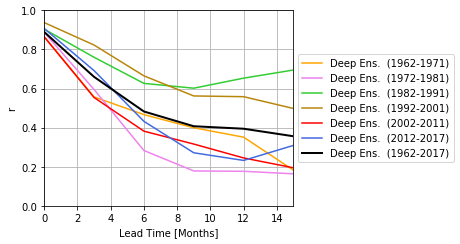

In [8]:
#%% =============================================================================
# All season correlation skill
# =============================================================================

plt.close("all")
# scores on the full time series
r, p  = evaluation_correlation('mlr', variable_name='prediction')

# score in different decades
r_dec, p_dec = evaluation_decadal_correlation('mlr', variable_name='prediction')

# plot correlation skills
ax = plt.figure(figsize=(6.5,3.5)).gca()

for j in range(n_decades-1):
    plt.plot(lead_times, r_dec[:,j], c=decade_color[j], label=f"Deep Ens.  ({decade_name[j]})")
plt.plot(lead_times, r, label="Deep Ens.  (1962-2017)", c='k', lw=2)

plt.ylim(0,1)
plt.xlim(0.,lead_times[-1])
plt.xlabel('Lead Time [Months]')
plt.ylabel('r')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

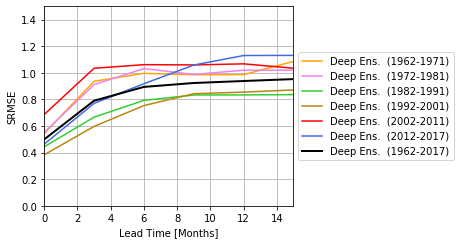

In [9]:
#%% =============================================================================
# All season SRMSE skill
# =============================================================================
srmse_dec = evaluation_decadal_srmse('mlr', variable_name='prediction')
srmse = evaluation_srmse('mlr', variable_name='prediction')

# plot SRMSE skills
ax = plt.figure(figsize=(6.5,3.5)).gca()
for j in range(n_decades-1):
    plt.plot(lead_times, srmse_dec[:,j], c=decade_color[j], label=f"Deep Ens.  ({decade_name[j]})")
plt.plot(lead_times, srmse, label="Deep Ens.  (1962-2017)", c='k', lw=2)

plt.ylim(0,1.5)
plt.xlim(0.,lead_times[-1])
plt.xlabel('Lead Time [Months]')
plt.ylabel('SRMSE')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()

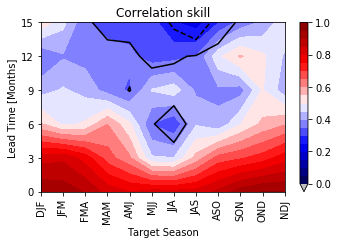

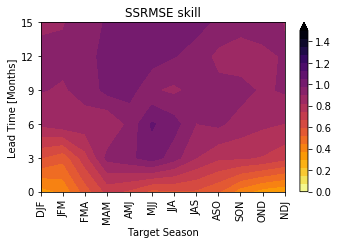

In [10]:
# =============================================================================
# Seasonal correlation skills
# =============================================================================
# evaluate the model in different seasons
r_seas, p_seas = evaluation_seasonal_correlation('mlr', variable_name='prediction')

plot_seasonal_skill(lead_times, r_seas,  vmin=0, vmax=1)
plt.contour(np.arange(1,13),lead_times, p_seas, levels=[0.01, 0.05, 0.1], linestyles=['solid', 'dashed', 'dotted'], colors='k')
plt.title('Correlation skill')
plt.tight_layout()

srsme_seas = evaluation_seasonal_srmse('mlr', variable_name='prediction')
plot_seasonal_skill(lead_times, srsme_seas,  vmin=0, vmax=1.5, cmap=plt.cm.inferno_r, extend='max')
plt.title('SSRMSE skill')
plt.tight_layout()